<a href="https://colab.research.google.com/github/dimi-fn/Kannada-Mnist-Digits/blob/main/Kannada_Mnist_Digits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# importing libraries for data analysis and manipulation
import pandas as pd
import numpy as np

In [2]:
np.random.seed(42) # to make this notebook's output stable across runs

# For plotting figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=15)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


# Generating the version of a wide variety of packages/libraries used & working environment
pd.__version__
pd.show_versions(as_json=False)


/usr/local/lib/python3.6/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)



INSTALLED VERSIONS
------------------
commit           : 2a7d3326dee660824a8433ffd01065f8ac37f7d6
python           : 3.6.9.final.0
python-bits      : 64
OS               : Linux
OS-release       : 4.19.112+
Version          : #1 SMP Thu Jul 23 08:00:38 PDT 2020
machine          : x86_64
processor        : x86_64
byteorder        : little
LC_ALL           : None
LANG             : en_US.UTF-8
LOCALE           : en_US.UTF-8

pandas           : 1.1.2
numpy            : 1.18.5
pytz             : 2018.9
dateutil         : 2.8.1
pip              : 19.3.1
setuptools       : 50.3.0
Cython           : 0.29.21
pytest           : 3.6.4
hypothesis       : None
sphinx           : 1.8.5
blosc            : None
feather          : 0.4.1
xlsxwriter       : None
lxml.etree       : 4.2.6
html5lib         : 1.0.1
pymysql          : None
psycopg2         : 2.7.6.1 (dt dec pq3 ext lo64)
jinja2           : 2.11.2
IPython          : 5.5.0
pandas_datareader: 0.9.0
bs4              : 4.6.3
bottleneck       : 1

In [3]:
import tensorflow as tf # open source Deep Leaning library
from tensorflow import keras # Deep Learning API
print ("Tensorflow version is {}".format(tf.__version__))
print ("Keras Version is {}".format(keras.__version__))

Tensorflow version is 2.3.0
Keras Version is 2.4.0


In [4]:
# Here we upload the .json file containing the credentials to use the API.
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"dimi44","key":"276cb4d2f2d28fb5c361b0ffa2ab546c"}'}

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [6]:
!pip install kaggle

In [7]:
# Download MNIST data
!kaggle competitions download -c cs98x-kannada-mnist --force 

 50% 5.00M/9.92M [00:00<00:00, 14.4MB/s]
100% 9.92M/9.92M [00:00<00:00, 25.0MB/s]
  0% 0.00/1.79M [00:00<?, ?B/s]
100% 1.79M/1.79M [00:00<00:00, 112MB/s]


In [8]:
#Unzip MNIST Data
import zipfile

with zipfile.ZipFile("test.csv.zip","r") as zip_ref:
    zip_ref.extractall("/content")
with zipfile.ZipFile("training.csv.zip","r") as zip_ref:
    zip_ref.extractall("/content")

In [9]:
# Load MNIST Data
kannada_test = pd.read_csv("test.csv")
kannada_train = pd.read_csv("training.csv")

# 1| Kannada Mnist Dataset
The task is to classify the kannada handwritten digits. 

## Exploration of the Dataset

In [10]:
kannada_train.tail(1) # last row of the train set

,id,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
59999,60000,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [11]:
kannada_test.head(1) # first row of the test set

,id,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,60001,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


So we can notice that every image is represented as a 1D array of size 784 (exluding the columns "id" and "label" in the train set, and "id" in the train set).

There is need to:
 - drop the the "id" column from the train and test set (since it will not offer any substantial contribution), and assign the column "label" as the training target (y_train_full).
 - convert the images into 2D array of 28x28 pixels in order to apply Deep Neural Networks (DNNs).

In [12]:
X_train_full_1= kannada_train.drop('id', axis=1)  
X_train_full= X_train_full_1.drop('label', axis=1)

X_test = kannada_test.drop(['id'], axis=1) 

y_train_full= kannada_train['label'].copy() #target

In [13]:
print ('Shape of X_train_full is: {}'.format(X_train_full.shape))
print ('#****************************************************************************#')

print ('Shape of y_train_full is: {}'.format(y_train_full.shape))
print ('#****************************************************************************#')

print ('Shape of X_test is: {}'.format(X_test.shape))
print ('#****************************************************************************#')


Shape of X_train_full is: (60000, 784)
#****************************************************************************#
Shape of y_train_full is: (60000,)
#****************************************************************************#
Shape of X_test is: (10000, 784)
#****************************************************************************#


In [14]:
#converting to 2D
X_train_full = X_train_full.values.reshape(X_train_full.shape[0], 28, 28,)
X_test = X_test.values.reshape(X_test.shape[0], 28, 28,)

Based on the data description, the pixel-value is an integer between 0 and 255, inclusive. Hence, below we will scale the pixel intensities down to 0-1 range by diving with 255.
> Along with that, we will split the training set into a smaller training set and a validation set, in order to proceed to evaluations in the validation set.
>> Validation set will get the first 5000 features (around 8% of the train set), and the rest will remain as training set.

In [15]:
X_valid, X_train = X_train_full[:5000] / 255, X_train_full[5000:] / 255 #from 60,000, we give 5,000 to validation
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255   # i did not put "." after 255 for float in order to have int

In [16]:
print ('Shape of X_train is: {}'.format(X_train.shape))
print ('Type of X_train is: {}'.format(X_train.dtype))
print ('#****************************************************************************#')

print ('Shape of X_valid is: {}'.format(X_valid.shape))
print ('Type of X_valid is: {}'.format(X_valid.dtype))
print ('#****************************************************************************#')

print ('Shape of y_train is: {}'.format(y_train.shape))
print ('Type of y_train is: {}'.format(y_train.dtype))
print ('#****************************************************************************#')

print ('Shape of y_valid is: {}'.format(y_valid.shape))
print ('Type of y_valid is: {}'.format(y_valid.dtype))
print ('#****************************************************************************#')


print ('Shape of X_test is: {}'.format(X_test.shape))
print ('Type of X_test is: {}'.format(X_test.dtype))
print ('#****************************************************************************#')

Shape of X_train is: (55000, 28, 28)
Type of X_train is: float64
#****************************************************************************#
Shape of X_valid is: (5000, 28, 28)
Type of X_valid is: float64
#****************************************************************************#
Shape of y_train is: (55000,)
Type of y_train is: int64
#****************************************************************************#
Shape of y_valid is: (5000,)
Type of y_valid is: int64
#****************************************************************************#
Shape of X_test is: (10000, 28, 28)
Type of X_test is: float64
#****************************************************************************#


> Below we can view the 1st digit of the train set:

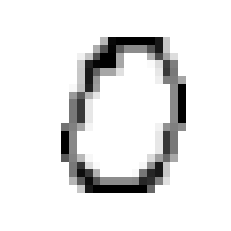

In [17]:
from matplotlib import pyplot as plt
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

## Building an image classifier using Gradient Descent and the Sequential API - Model 1

> meaning of: #model.add(keras.layers.Flatten(input_shape=[28, 28])):
>> This is the 1st layer which we add to the model. It is a flatten layer and its role is to do some preprocessing, and we also specify the input shape of the images.

> Then we add two hidden dense layers with 300 and 100 neurons repsectively, using the Rectified Linear Unit (ReLU) activation function.

>> Contrary to biological neurons, it has been proved that ReLU activation function is more efficient in deep networks than the logistic-sigmoid activation function (because it does not saturate for positive values and is fast to compute).



> In the end we add a dense output layer with 10 neurons, since we have 10 classes, using the softmax activation function (since the classes are exclusive).

In [18]:
model1 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

> Model's summary() method displays all the model's layers:

    - layers' names
    - output shape ('none' means the batch size is not specified-can be anything)
    - the number of parameters
    - total number of parameters
    - number of trainable and non-trainable parameters

>From the model's summary we can exclude that the 1st hidden layer has 784x300 connection weights, plus 300 bias terms, which adds up to 235,500 parameters and to 266,610 in total.


In [19]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


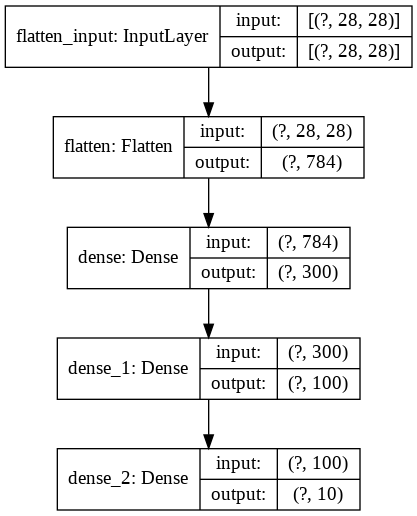

In [20]:
keras.utils.plot_model(model1, show_shapes=True)

### Compiling the model:
> After a model is created, we use the compile() method to specify:
- the loss function
- the optimiser

>> Using "sparse_categorical_crossentropy" in the loss function since there is one target class per instance (i.e. digit number 1 or 2 and so on), and using Stohastic Gradient Desenct as optimiser:

In [21]:
model1.compile(loss="sparse_categorical_crossentropy", #one target class per instance
              optimizer="sgd",                   #Stohastic Gradient Descent
              metrics=["accuracy"])

In the end, we can fit the model and train it, here for 30 epochs, and then it can be evaluated on the validation set:

In [22]:
# X_train -> train predictors ~ input features
# y_train -> train targets ~ target classes 

history = model1.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.6541 - accuracy: 0.8458 - val_loss: 0.2848 - val_accuracy: 0.9300
Epoch 2/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2434 - accuracy: 0.9337 - val_loss: 0.2535 - val_accuracy: 0.9378
Epoch 3/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2049 - accuracy: 0.9445 - val_loss: 0.2325 - val_accuracy: 0.9408
Epoch 4/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.1833 - accuracy: 0.9502 - val_loss: 0.2339 - val_accuracy: 0.9392
Epoch 5/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.1673 - accuracy: 0.9550 - val_loss: 0.2247 - val_accuracy: 0.9388
Epoch 6/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.1543 - accuracy: 0.9580 - val_loss: 0.2189 - val_accuracy: 0.9422
Epoch 7/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.1424 - accuracy: 0.9613 - val_loss: 0.2067 - val_accuracy:

In [23]:
model1.evaluate(X_valid, y_valid)

157/157 [==============================] - 0s 2ms/step - loss: 0.1739 - accuracy: 0.9556


[0.17393504083156586, 0.9556000232696533]

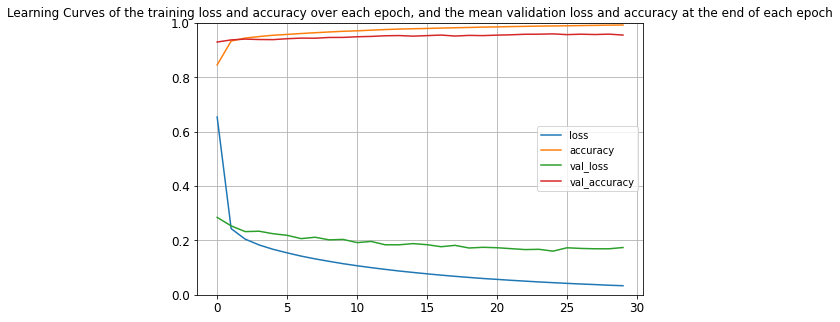

In [24]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # setting the vertical range to [0,1]
plt.title('Learning Curves of the training loss and accuracy over each epoch, and the mean validation loss and accuracy at the end of each epoch')
plt.show()

# Training and validation curves are close between them, 
# fact which implies that not too much overfitting is taking place

In [25]:
y_test = model1.predict(X_test)
y_test


array([[9.9855477e-01, 2.1289408e-05, 1.1268777e-08, ..., 2.0957428e-05,
        1.4025213e-03, 1.2314215e-08],
       [1.9340102e-02, 9.7964901e-01, 9.6449541e-04, ..., 4.8537629e-07,
        3.5498229e-07, 1.9133656e-10],
       [3.6579213e-06, 1.2843881e-04, 9.9986768e-01, ..., 1.8299996e-08,
        2.3387965e-09, 2.1091939e-09],
       ...,
       [1.7316993e-06, 1.3195247e-08, 9.5178398e-09, ..., 3.0218038e-07,
        9.9993002e-01, 1.0479710e-05],
       [9.0448237e-05, 2.2371493e-03, 8.4002124e-05, ..., 1.7302954e-03,
        3.4500787e-03, 9.9239677e-01],
       [2.5475210e-02, 8.3916663e-04, 4.3503592e-06, ..., 5.5155810e-04,
        8.2843155e-03, 9.6422064e-01]], dtype=float32)

In [26]:
predictions = model1.predict_classes(X_test)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [27]:
len(predictions)

10000

In [28]:
predictions

array([0, 1, 2, ..., 8, 9, 9])

In [29]:
submission= pd.DataFrame({'id': kannada_test['id'], 'label': predictions})
submission

,id,label
0,60001,0
1,60002,1
2,60003,2
3,60004,3
4,60005,4
...,...,...
9995,69996,6
9996,69997,7
9997,69998,8
9998,69999,9


In [30]:
from google.colab import files
'''
from google.colab import files
predictions = model1.predict_classes(X_test)
submission= pd.DataFrame({'id': kannada_test['id'], 'label': predictions})
submission.to_csv('predictions_01.csv', index = False) 
files.download('predictions_01.csv') score: 0.95533  *****************************************************************************
'''

"\nfrom google.colab import files\npredictions = model1.predict_classes(X_test)\nsubmission= pd.DataFrame({'id': kannada_test['id'], 'label': predictions})\nsubmission.to_csv('predictions_01.csv', index = False) \nfiles.download('predictions_01.csv') score: 0.95533  *****************************************************************************\n"

## Challenges in DNNs

The flexibility of neural networks coming from the large number of parameters used can lead to the risk of overfitting. Some of the hyperparameters than can be changed are:
- number of layers
- number of neurons per layer
- type of activation function in each layer
- weight initialisation logic

Also, DNNs suffer from the vanishing/exploding gradients problem (different layers may learn at widely different speeds). One way to alleviate it is by applying the Batch Normalisation technique.


## Model 2
Creating a DNN model with 20 hidden layers of 50 neurons each, using He normal initialisation, ELU activation function and nadam optimiser. In addition, we implement early stopping using keras.callbacks: it will interrupt training when it measures no progress on the validation set for a number of epochs defined by the 'patience' argument (here patience=20). The number of epochs can be set to a large value since the model will stop if no progress is found in the indicated patience number.


In [31]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model2 = keras.models.Sequential()
model2.add(keras.layers.Flatten(input_shape=[28, 28]))
for _ in range(20):
    model2.add(keras.layers.Dense(50,
                                 activation="elu",
                                 kernel_initializer="he_normal"))
    
model2.add(keras.layers.Dense(10, activation="softmax"))


optimizer = keras.optimizers.Nadam(lr=5e-5)
model2.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)

callbacks = [early_stopping_cb]

In [32]:
model2.fit(X_train, y_train, epochs=50,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

Epoch 1/50
1719/1719 [==============================] - 15s 9ms/step - loss: 0.9346 - accuracy: 0.7030 - val_loss: 0.3681 - val_accuracy: 0.8920
Epoch 2/50
1719/1719 [==============================] - 14s 8ms/step - loss: 0.3169 - accuracy: 0.9065 - val_loss: 0.2893 - val_accuracy: 0.9202
Epoch 3/50
1719/1719 [==============================] - 15s 8ms/step - loss: 0.2274 - accuracy: 0.9333 - val_loss: 0.2684 - val_accuracy: 0.9234
Epoch 4/50
1719/1719 [==============================] - 14s 8ms/step - loss: 0.1832 - accuracy: 0.9455 - val_loss: 0.2451 - val_accuracy: 0.9304
Epoch 5/50
1719/1719 [==============================] - 15s 8ms/step - loss: 0.1546 - accuracy: 0.9541 - val_loss: 0.2577 - val_accuracy: 0.9294
Epoch 6/50
1719/1719 [==============================] - 14s 8ms/step - loss: 0.1341 - accuracy: 0.9609 - val_loss: 0.2534 - val_accuracy: 0.9330
Epoch 7/50
1719/1719 [==============================] - 15s 9ms/step - loss: 0.1191 - accuracy: 0.9653 - val_loss: 0.2350 - val_ac

In [33]:
model2.evaluate(X_valid, y_valid)

157/157 [==============================] - 0s 2ms/step - loss: 0.3282 - accuracy: 0.9438


[0.3281937539577484, 0.9437999725341797]

In [34]:
'''
predictions = model2.predict_classes(X_test)
submission= pd.DataFrame({'id': kannada_test['id'], 'label': predictions})
submission.to_csv('predictions_02.csv', index = False) 
files.download('predictions_02.csv') #  score: 0.8757 *****************************************************************************
'''

"\npredictions = model2.predict_classes(X_test)\nsubmission= pd.DataFrame({'id': kannada_test['id'], 'label': predictions})\nsubmission.to_csv('predictions_02.csv', index = False) \nfiles.download('predictions_02.csv') #  score: 0.8757 *****************************************************************************\n"

## Model 3

Below we have approximately the same model, but changing the learning rate (increasing it) to 5e-4 and adding batch normalisation (BN). Also reducing the patience down to 5 since this model requires a lot time (it requires better handling of the parameters and learning schedule to speed up training)

More specifically, BN adds 4 parameters per input, and these are: β, γ, μ and σ,
where:

> β and γ are learnt though regular backpropagation
>> β: the output offset (shift) vector

>> γ: the output scale vector


> μ and σ are estimated through training but they are used only after training. They are called the "moving averages" and they are not affected by the backpropagation (in the model summary, keras calls them "non-trainable" meaning untouched by the backpropagation).
>> μ: the final input mean vector

>> σ: the final input standard deviation vector


In [35]:
# please uncomment the following code
# it is on comments because it takes approximately 10-15 min totally to be executed (based also on when patience gets "activated")
# when it was executed the result on the 30% of the test set in kaggle had score: 89.83% and 92.27% in the validation set

'''
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model3 = keras.models.Sequential()
model3.add(keras.layers.Flatten(input_shape=[28,28]))
model3.add(keras.layers.BatchNormalization())
for _ in range(20):
    model3.add(keras.layers.Dense(100, kernel_initializer="he_normal"))
    model3.add(keras.layers.BatchNormalization())
    model3.add(keras.layers.Activation("elu"))
model3.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.Nadam(lr=5e-4)
model3.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=5)

callbacks = [early_stopping_cb]

model3.fit(X_train, y_train, epochs=50,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)
'''

'\nkeras.backend.clear_session()\ntf.random.set_seed(42)\nnp.random.seed(42)\n\nmodel3 = keras.models.Sequential()\nmodel3.add(keras.layers.Flatten(input_shape=[28,28]))\nmodel3.add(keras.layers.BatchNormalization())\nfor _ in range(20):\n    model3.add(keras.layers.Dense(100, kernel_initializer="he_normal"))\n    model3.add(keras.layers.BatchNormalization())\n    model3.add(keras.layers.Activation("elu"))\nmodel3.add(keras.layers.Dense(10, activation="softmax"))\n\noptimizer = keras.optimizers.Nadam(lr=5e-4)\nmodel3.compile(loss="sparse_categorical_crossentropy",\n              optimizer=optimizer,\n              metrics=["accuracy"])\n\nearly_stopping_cb = keras.callbacks.EarlyStopping(patience=5)\n\ncallbacks = [early_stopping_cb]\n\nmodel3.fit(X_train, y_train, epochs=50,\n          validation_data=(X_valid, y_valid),\n          callbacks=callbacks)\n'

In [36]:
# model3.summary()

In [37]:
'''
predictions = model3.predict_classes(X_test)
submission= pd.DataFrame({'id': kannada_test['id'], 'label': predictions})
submission.to_csv('predictions_3.csv', index = False) 
files.download('predictions_3.csv') #  score: 0.89833 *****************************************************************************
'''

"\npredictions = model3.predict_classes(X_test)\nsubmission= pd.DataFrame({'id': kannada_test['id'], 'label': predictions})\nsubmission.to_csv('predictions_3.csv', index = False) \nfiles.download('predictions_3.csv') #  score: 0.89833 *****************************************************************************\n"

# From DNNs to Convolutional Neural Networks (CNNs)

Compared to DNNs model, building a CNN model requires two additional blocks: convolutional layers and pooling layers. In CNNs the small regions of the visual field are called receptive fields,  kernel size reflects the shape of filters, and the latter (filters) reflect the feature maps.


## CNN model

Creating a CNN model, in which there are:

> 64 filters (7x7). No stride-shift because the input images are not very large. Input shape will be 28,28,1 (hence it requires a right conversion) because images are 28x28 pixels, 1 because there is 1 single color channel based on the kaggle dataset information (gray scale). Also using padding=same which means that the layer's outputs will have the same spatial dimensions (width and height) as its inputs, hence the name 'same', and adam optimiser.


> one max pooling layer with a pool size of 2. This means that it divides each spatial dimension (i.e. height and width) by a factor of 2.

> We repeat the same structure twice (2 convolutional layers followed by 1 max pooling layer, doubling the filters after each pooling layer as we move forward to the output layer.

>>Since the max pooling layers divides each spatial dimension by a factor of 2, we can afford to double the number of feature maps in the next layer. 

> Consequently, we have a fully connected network, composed of 2 hidden dense layers and a dense output layer. We have to flatten its inputs since a dense network expects a 1D array of features for each instance, and also we add 2 dropout layers with a dropout rate of 50% each to reduce overfitting.

>>> First we need to fix the shape of the input images, since Keras will expect 4D tensor, by expanding the dimensions from three to four.

In [38]:
# current shape:

print ('Shape of X_train is: {}'.format(X_train.shape))
print ('Type of X_train is: {}'.format(X_train.dtype))
print ('#****************************************************************************#')

print ('Shape of X_valid is: {}'.format(X_valid.shape))
print ('Type of X_valid is: {}'.format(X_valid.dtype))
print ('#****************************************************************************#')

print ('Shape of y_train is: {}'.format(y_train.shape))
print ('Type of y_train is: {}'.format(y_train.dtype))
print ('#****************************************************************************#')

print ('Shape of y_valid is: {}'.format(y_valid.shape))
print ('Type of y_valid is: {}'.format(y_valid.dtype))
print ('#****************************************************************************#')


print ('Shape of X_test is: {}'.format(X_test.shape))
print ('Type of X_test is: {}'.format(X_test.dtype))
print ('#****************************************************************************#')

Shape of X_train is: (55000, 28, 28)
Type of X_train is: float64
#****************************************************************************#
Shape of X_valid is: (5000, 28, 28)
Type of X_valid is: float64
#****************************************************************************#
Shape of y_train is: (55000,)
Type of y_train is: int64
#****************************************************************************#
Shape of y_valid is: (5000,)
Type of y_valid is: int64
#****************************************************************************#
Shape of X_test is: (10000, 28, 28)
Type of X_test is: float64
#****************************************************************************#


In [39]:
def expand_dimension(x):
  return np.expand_dims(x, -1)

In [40]:
X_train = expand_dimension(X_train)
X_test = expand_dimension(X_test)
X_valid = expand_dimension(X_valid)

In [41]:
# The new shape in 4D tensor
print('Train: X=%s, y=%s' % (X_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (X_test.shape, y_test.shape))
print('Valid: X=%s, y=%s' % (X_valid.shape, y_valid.shape))


print ("********************************************************************************")

print("X_train_full shape is {}".format(X_train_full.shape))

print("y_train_full shape is {}".format(y_train_full.shape))

print ("*             *             *                  *                    *             *")

print("X_test shape is {}".format(X_test.shape))

print("y_test shape is {}".format(y_test.shape))

print("X_valid shape is {}".format(X_valid.shape))

print("X_train shape is {}".format(X_train.shape))

print("y_valid shape is {}".format(y_valid.shape))

print("y_train shape is {}".format(y_train.shape))
print ("********************************************************************************")

Train: X=(55000, 28, 28, 1), y=(55000,)
Test: X=(10000, 28, 28, 1), y=(10000, 10)
Valid: X=(5000, 28, 28, 1), y=(5000,)
********************************************************************************
X_train_full shape is (60000, 28, 28)
y_train_full shape is (60000,)
*             *             *                  *                    *             *
X_test shape is (10000, 28, 28, 1)
y_test shape is (10000, 10)
X_valid shape is (5000, 28, 28, 1)
X_train shape is (55000, 28, 28, 1)
y_valid shape is (5000,)
y_train shape is (55000,)
********************************************************************************


In [42]:
model4 = keras.models.Sequential([
                                 
  keras.layers.Conv2D(filters= 64, kernel_size=7, activation="relu", padding="same", input_shape=[28, 28, 1]), 
  keras.layers.MaxPooling2D(pool_size=2),                                                           

  keras.layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding="same"),                         
  keras.layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding="same"),                         
  keras.layers.MaxPooling2D(pool_size=2),   

  keras.layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding="same"),                          
  keras.layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding="same"),                        
  keras.layers.MaxPooling2D(pool_size=2),                                                           

  keras.layers.Flatten(),
  keras.layers.Dense(units=128, activation="relu"),             
  keras.layers.Dropout(0.5), 
  keras.layers.Dense(units=64, activation="relu"),            
  keras.layers.Dropout(0.5), 

  keras.layers.Dense(units=10, activation="softmax")          
])

model4.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model4.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        3200      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 256)         295168    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 256)        

In [43]:
history = model4.fit(X_train, y_train, epochs=25, validation_data=(X_valid, y_valid))

Epoch 1/25
1719/1719 [==============================] - 11s 6ms/step - loss: 0.4230 - accuracy: 0.8621 - val_loss: 0.1538 - val_accuracy: 0.9660
Epoch 2/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.1013 - accuracy: 0.9753 - val_loss: 0.1500 - val_accuracy: 0.9632
Epoch 3/25
1719/1719 [==============================] - 11s 6ms/step - loss: 0.0728 - accuracy: 0.9827 - val_loss: 0.1080 - val_accuracy: 0.9732
Epoch 4/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.0578 - accuracy: 0.9861 - val_loss: 0.0944 - val_accuracy: 0.9790
Epoch 5/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.0540 - accuracy: 0.9873 - val_loss: 0.1071 - val_accuracy: 0.9806
Epoch 6/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.0418 - accuracy: 0.9892 - val_loss: 0.1045 - val_accuracy: 0.9822
Epoch 7/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.0377 - accuracy: 0.9902 - val_loss: 0.1086 - val_ac

In [44]:
model4.evaluate(X_valid, y_valid)

157/157 [==============================] - 0s 3ms/step - loss: 0.1356 - accuracy: 0.9786


[0.13558286428451538, 0.978600025177002]

In [45]:
'''
predictions = model4.predict_classes(X_test)
submission= pd.DataFrame({'id': kannada_test['id'], 'label': predictions})
submission.to_csv('predictions_cnn01.csv', index = False) 
files.download('predictions_cnn01.csv') # score: 0.9650  *****************************************************************************
'''

"\npredictions = model4.predict_classes(X_test)\nsubmission= pd.DataFrame({'id': kannada_test['id'], 'label': predictions})\nsubmission.to_csv('predictions_cnn01.csv', index = False) \nfiles.download('predictions_cnn01.csv') # score: 0.9650  *****************************************************************************\n"

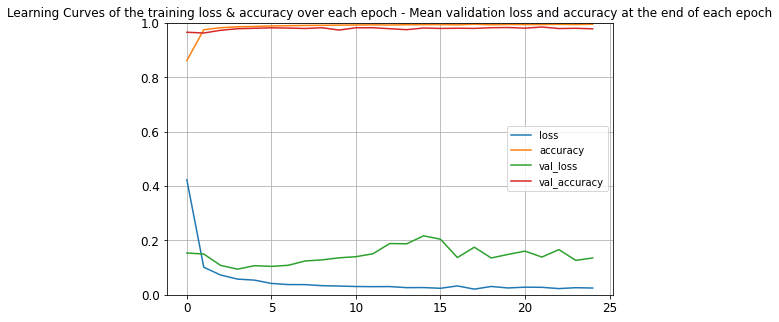

In [46]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # setting the vertical range to [0,1]
plt.title('Learning Curves of the training loss & accuracy over each epoch - Mean validation loss and accuracy at the end of each epoch')
plt.show()

# Training and validation curves are close between them, 
# fact which implies that not too much overfitting is taking place
# although the flunctations of the curves seem bigger than those of the 1st DNN model 

## Model 5

In [47]:
model5 = keras.models.Sequential([
                                 
  keras.layers.Conv2D(filters= 64, kernel_size=7, activation="relu", padding="same", input_shape=[28, 28, 1]), 
  keras.layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding="same"),   
  keras.layers.BatchNormalization(),
  keras.layers.MaxPooling2D(pool_size=2),  
                                        

  keras.layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding="same"),                         
  keras.layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding="same"),    
  keras.layers.BatchNormalization(),                  
  keras.layers.MaxPooling2D(pool_size=2), 
                                                                    

  keras.layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding="same"),                          
  keras.layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding="same"),    
  keras.layers.BatchNormalization(),                    
  keras.layers.MaxPooling2D(pool_size=2),      
  keras.layers.Dropout(0.50),                                                  


  keras.layers.Flatten(),
  keras.layers.Dense(units=128, activation="relu"),             
  keras.layers.Dropout(0.5), 
  keras.layers.Dense(units=64, activation="relu"),            
  keras.layers.Dropout(0.50), 

  keras.layers.Dense(units=10, activation="softmax")          
])

model5.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model5.summary()

history = model5.fit(X_train, y_train, epochs=25, validation_data=(X_valid, y_valid))


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 28, 28, 64)        3200      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 128)       512       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 128)       147584    
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 128)       147584    
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 128)      

In [48]:
'''
predictions = model5.predict_classes(X_test)
submission= pd.DataFrame({'id': kannada_test['id'], 'label': predictions})
submission.to_csv('predictions_cnn_model55.csv', index = False) 
files.download('predictions_cnn_model55.csv') # score: 0.97133  *****************************************************************************
'''

"\npredictions = model5.predict_classes(X_test)\nsubmission= pd.DataFrame({'id': kannada_test['id'], 'label': predictions})\nsubmission.to_csv('predictions_cnn_model55.csv', index = False) \nfiles.download('predictions_cnn_model55.csv') # score: 0.97133  *****************************************************************************\n"

# Conclusions

As expected, the CNN models performed better compared to the three previous DNN models.

In general, some of the main differences among DNNs and CNNs (and advantages over CNNs) are that:
-	Once a DNN has learned to recognise a pattern in one location, it can recognise it only in that particular location. On the contrary, once a CNN has learned to recognise a pattern in one location, it can recognise it in any other location.
-	CNNs consist of consecutive layers which are only partially connected and they heavily reuse their weights. This fact makes CNNs to have fewer parameters than a fully connected, being faster to train, reducing risk of overfitting and requiring less training data.





 Model|Number|Parameters and Configuration| Validation set| Test set (30%)
--- | ||---|--
DNN |1|Gradient Descent - Sequential API / 2 hidden layers with 300 and 100 neurons each/ ReLU activation function/ SGD optimiser|95.64%| 95.53%
DNN |2|20 hidden layers, 50 neurons each/ He normal initialisation/ ELU activation function/ nadam optimiser/ lr=5e-5| 94.38%| 87.57%
DNN |3| Approximately same as model 2 but: lr= 5e-4 plus Batch Normalisation |92.27%|89.83%
CNN |4| 5 convolutional layers with ascending number of filters as moving towards the output layer/ 3 max pooling layers/ adam optimiser/ 2 dropout layers of 50%|98.26%|96.50%
CNN |5 |Model 4 plus 1 convolutional layer, plus  Batch Normalisation and one more dropping layer |98.48%|97.13%

The above figure illustrates the models' scores both in validation set and kaggle's test set (divergence in results might occur when models' execution is repeated). 

Overall and specifically for this particular task, the 2nd CNN model ("model 5") reached 98.48% classification accuracy in the validation set and approximately 97.13% accuracy in the test set (based on 30% of the available test set in kaggle competition) setting it a benchmark here. It is an extended version of the first CNN model ("model 4") in which an extra convolutional layer was added after the first one, with also batch normalisation before every max pooling layer in order to to alleviate the unstable gradients problem, and finally one more dropout layer of 50% rate was added (before flattening the inputs) in order to avoid even more overfitting in this deeper network.

As a consequence, the second CNN model ("model 5") is the baseline for this task not only because it got the highest result, but because it can also be supported it can generalise better compared to the previous models. In kaggle competition, the second and third choice is the 4th and 1st model respectively.